1. QC

# Environment

In [1]:
# Standard library imports
import os
import gc
import pickle
import importlib

# Data manipulation imports
import pandas as pd
import scanpy as sc
import scrublet as scr
import polars as pl

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# pycisTopic imports
import pycisTopic
from pycisTopic.lda_models import run_cgs_models_mallet, evaluate_models
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
from pycisTopic.utils import fig2img
from pycisTopic.topic_binarization import binarize_topics
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments, merge
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

importlib.reload(pycisTopic)
from pycisTopic import *
pycisTopic.__version__

sys.path.insert(0, "/home/michal.kubacki/Githubs/Re-MEND/code/External_Datasets/GeneSet_Derivation/Herring_scenic/helpers")
import config
importlib.reload(config)
from config import *
n_cpus = 32

In [2]:
#################################################################
reference = "hg19"


# neurons_set = "all_excitatory"
# neurons_set = "all_inhibitory"
neurons_set = "all_excitatory_all_ages"
# neurons_set = "all_inhibitory_all_ages"

cells_dict = {
    "all_inhibitory"            :   ['SST', 'VIP', 'MGE_dev'],
    "all_inhibitory_all_ages"   :   ['VIP', 'SST', 'PV', 'MGE_dev'],
    "all_excitatory"            :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev'],
    "all_excitatory_all_ages"   :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev']
}

ages_dict = {
    "all_inhibitory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_inhibitory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24'],
    "all_excitatory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_excitatory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24']
}

out_dir, in_dir, root_dir, tmp_dir, data_folder = set_output_folders(reference, neurons_set)

sel_celltypes  = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

#################################################################

root_dir: /group/testa/michal.kubacki/herring
out_dir: /group/testa/michal.kubacki/herring/output_hg19_all_excitatory
in_dir: /group/testa/michal.kubacki/herring/data
tmp_dir: /group/testa/michal.kubacki/herring/tmp


In [3]:
fragments_dict = select_files(reference, selected_fragments = sel_ages)

All fragments: {'ga22': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138510_RL2366_ga22_snATAC_fragments.tsv.gz', '1y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138526_RL2209_1y_snATAC_fragments.tsv.gz', '14y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138542_RL2372_14y_snATAC_fragments.tsv.gz', 'ga24': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138512_RL2207_ga24_snATAC_fragments.tsv.gz', '2y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138529_RL1784_2y_snATAC_fragments.tsv.gz', '16y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138544_RL1785_16y_snATAC_fragments.tsv.gz', '1m': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138515_RL2367_1m_snATAC_fragments.tsv.gz', '4y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138532_RL2210_4y_snATAC_fragments.tsv.gz', '20y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138548_RL2085_20y_snATAC_fragment

# QC

In [ ]:
os.environ["PATH"] = "/home/michal.kubacki/.conda/envs/scenicplus/bin:" + os.environ["PATH"]

In [4]:
# %%script false --no-raise-error 
!pycistopic tss gene_annotation_list | grep hg19

In [5]:
# %%script false --no-raise-error 
!mkdir -p /group/testa/michal.kubacki/herring/output_hg19_all_excitatory/qc
!pycistopic tss get_tss \
    --output /group/testa/michal.kubacki/herring/output_hg19_all_excitatory/qc/tss.bed \
    --name "hsapiens_gene_ensembl" \
    --to-chrom-source ucsc \
    --ucsc hg19

- Get TSS annotation from Ensembl BioMart with the following settings:
  - biomart_name: "hsapiens_gene_ensembl"
  - biomart_host: "http://www.ensembl.org"
  - transcript_type: ['protein_coding']
  - use_cache: True
- Getting chromosome sizes and alias mapping for "hg19" from UCSC.
- Update chromosome names in TSS annotation to "ucsc" chromosome names.
- Writing TSS annotation BED file to "../herring/output_hg19_all_excitatory/qc/tss.bed".


In [6]:
# %%script false --no-raise-error 
!head ../herring/output_hg19_all_excitatory/qc/tss.bed | column -t

head: cannot open 'herring/output_hg19_all_excitatory/qc/tss.bed' for reading: No such file or directory


In [7]:
out_dir

'/group/testa/michal.kubacki/herring/output_hg19_all_excitatory'

In [8]:
# %%script false --no-raise-error
regions_bed_filename = os.path.join(out_dir, "consensus_peak_calling", "consensus_regions.bed")
tss_bed_path = "../herring/output_hg19_all_excitatory/qc"
os.makedirs(tss_bed_path, exist_ok = True)
tss_bed_filename = os.path.join(tss_bed_path, "tss.bed")

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'qc', sample)}",
            sep=" ",
            file=fh,
        )

In [9]:
!cat pycistopic_qc_commands.txt | parallel -j 1 {}

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2024, April 22). GNU Parallel 20240422 ('Børsen').
  Zenodo. https://doi.org/10.5281/zenodo.11043435

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 27 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?



In [10]:
fragments_dict

{'1m': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138515_RL2367_1m_snATAC_fragments.tsv.gz',
 '3m': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138518_RL1914_3m_snATAC_fragments.tsv.gz',
 '6m': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138521_RL2208_6m_snATAC_fragments.tsv.gz',
 '10m': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138523_RL2371_10m_snATAC_fragments.tsv.gz',
 '1y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138526_RL2209_1y_snATAC_fragments.tsv.gz',
 '2y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138529_RL1784_2y_snATAC_fragments.tsv.gz',
 '4y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138532_RL2210_4y_snATAC_fragments.tsv.gz',
 'ga22': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138510_RL2366_ga22_snATAC_fragments.tsv.gz',
 'ga24': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138512_RL2207_ga24_snATAC_fragments.tsv.gz'}

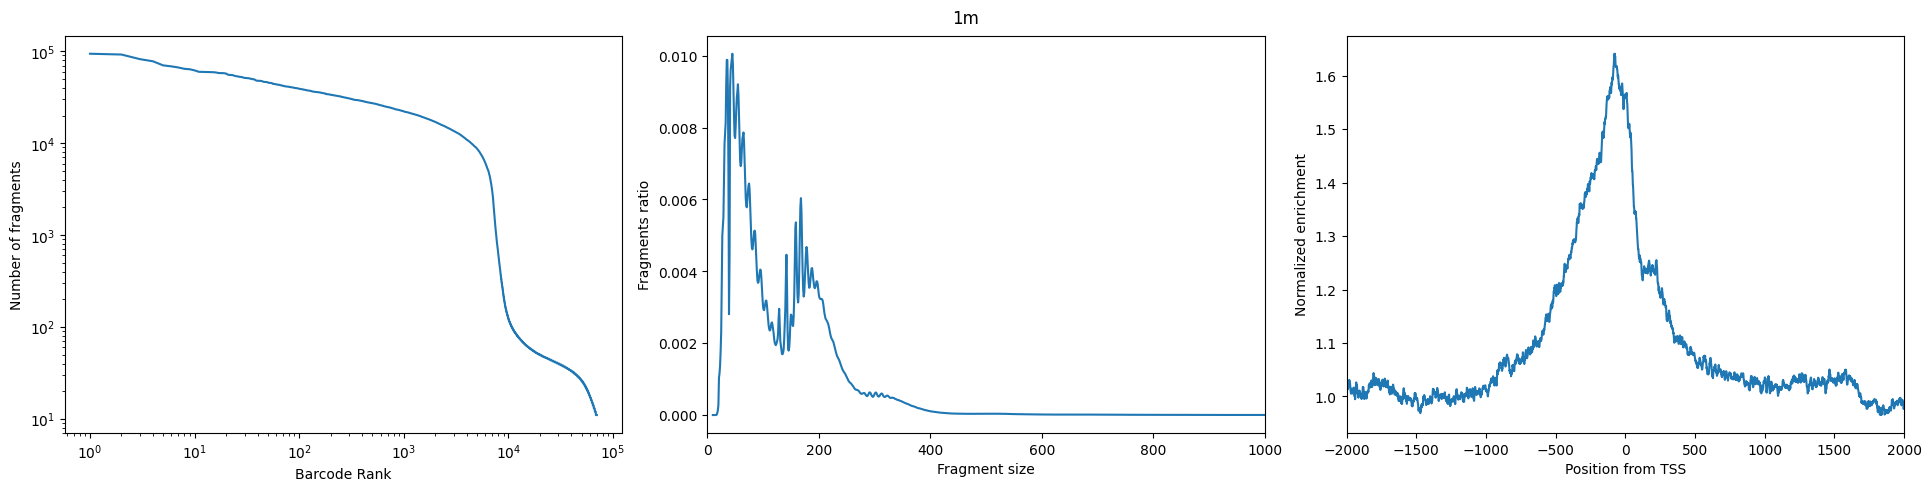

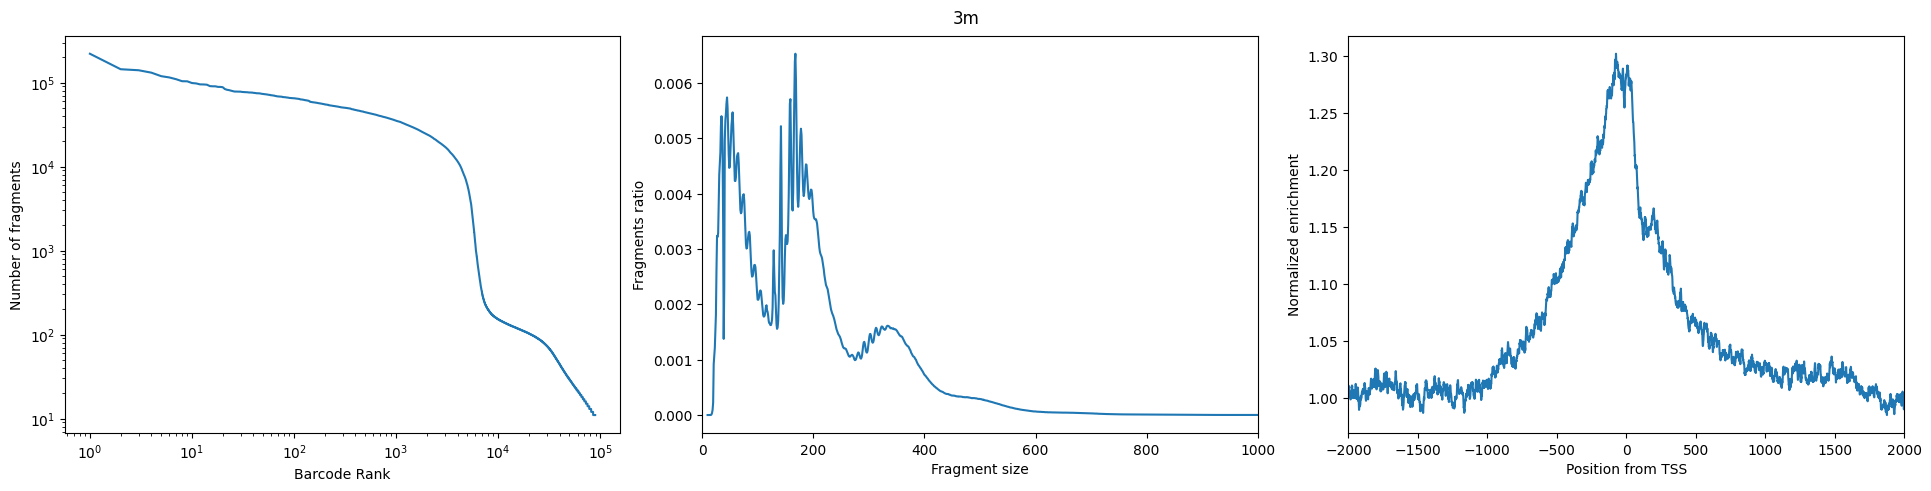

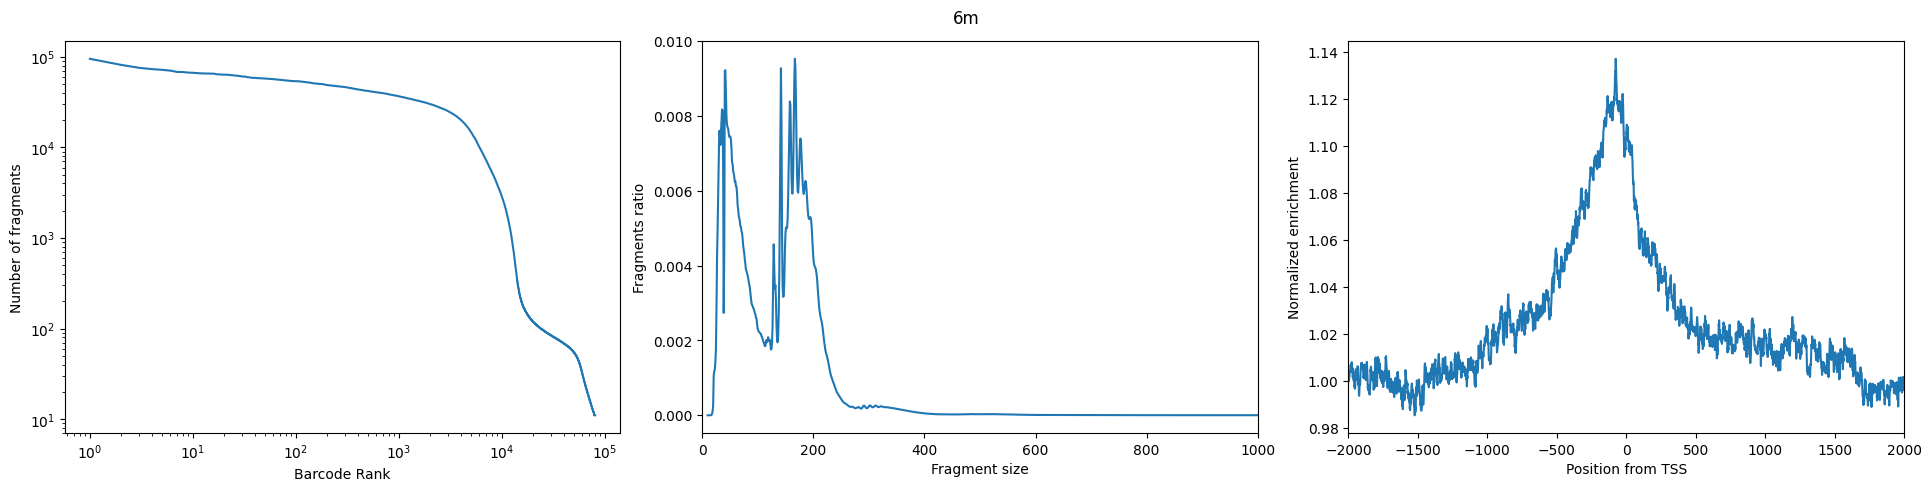

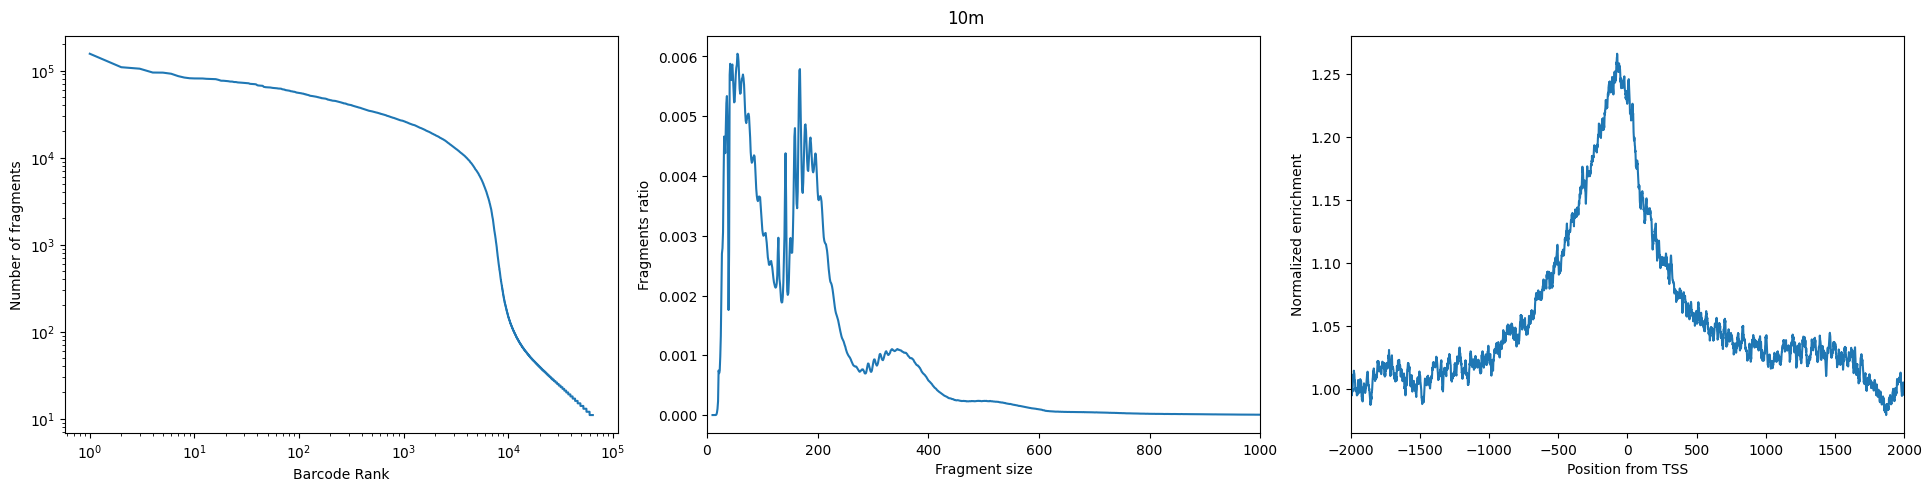

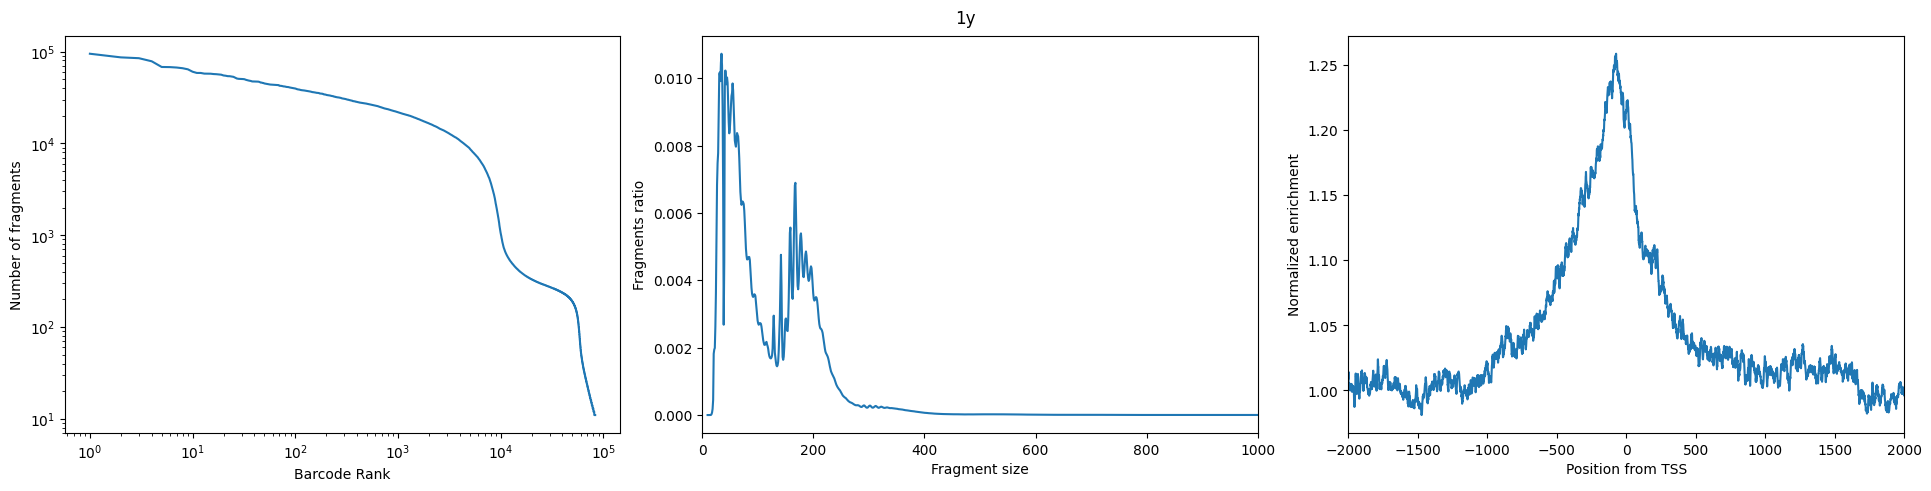

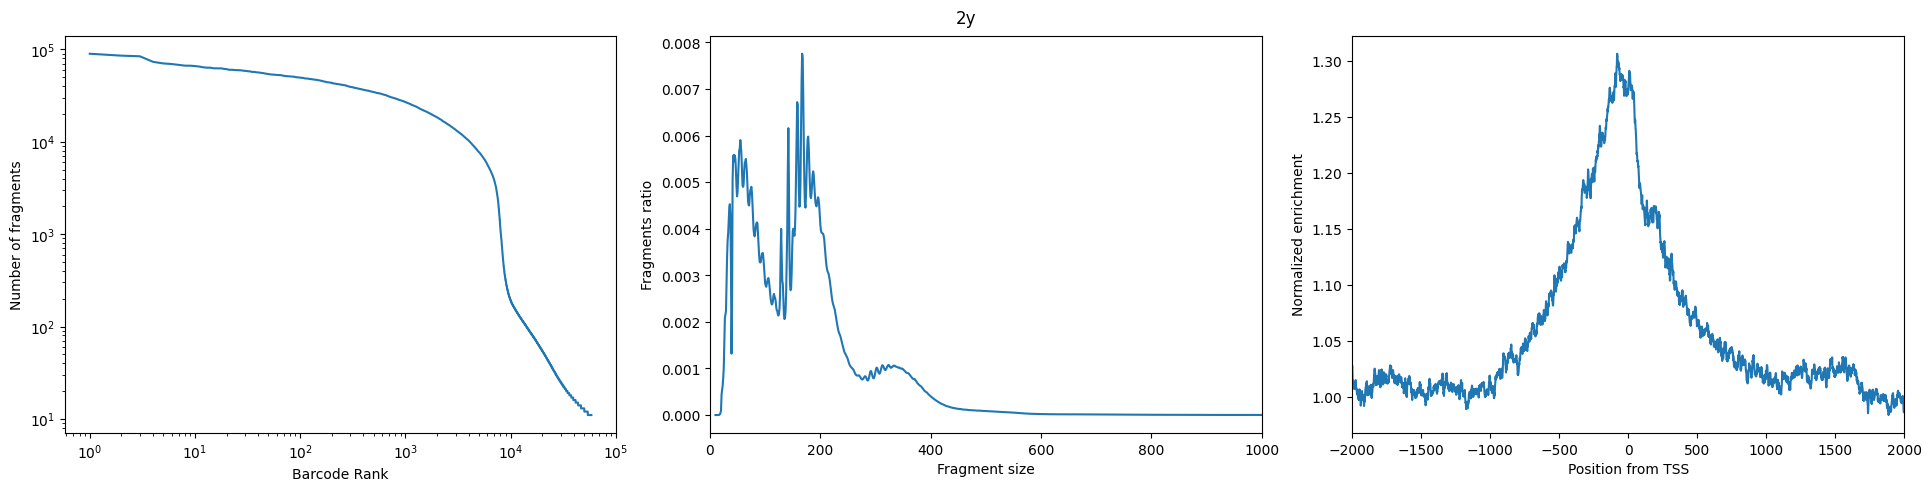

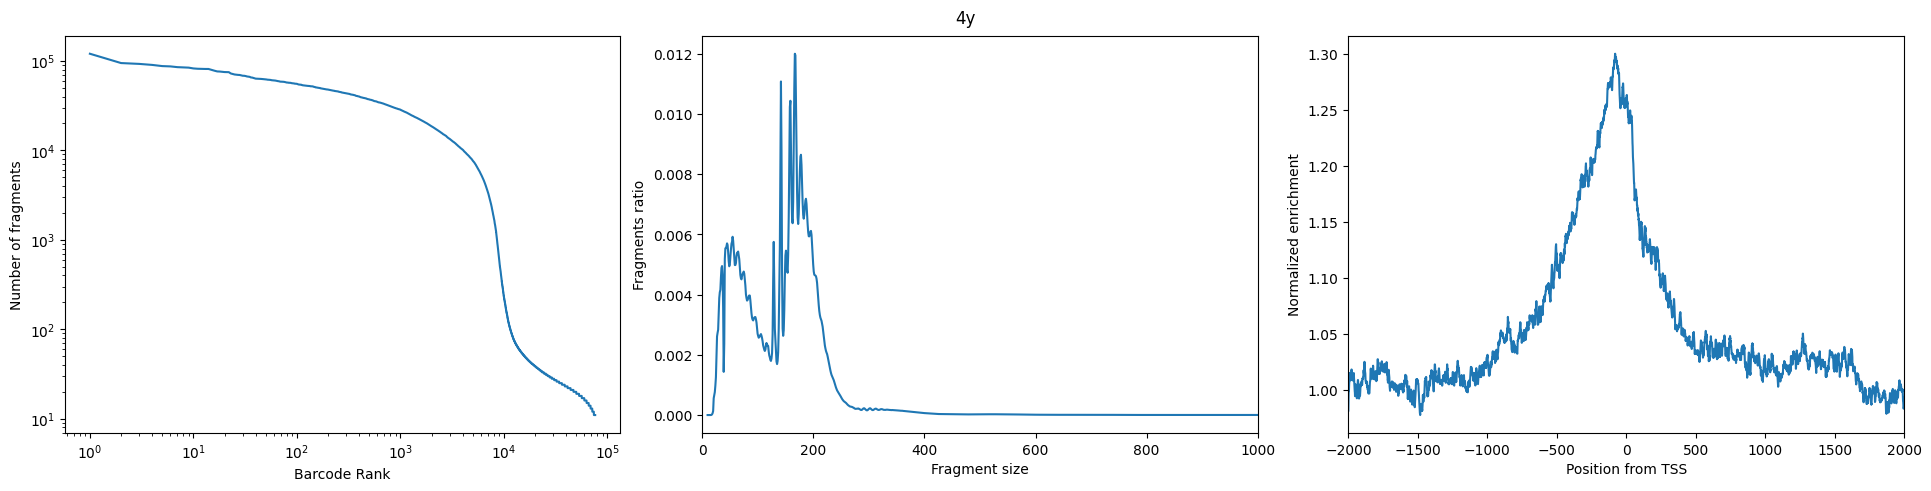

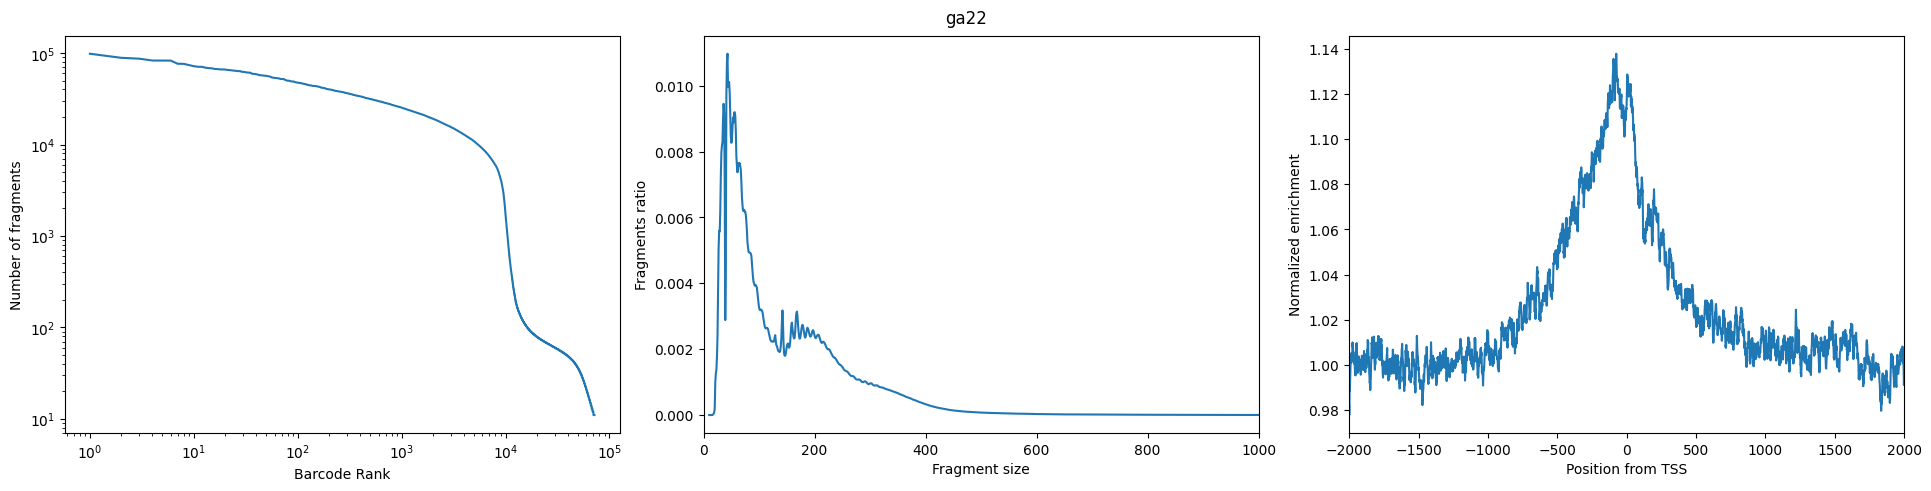

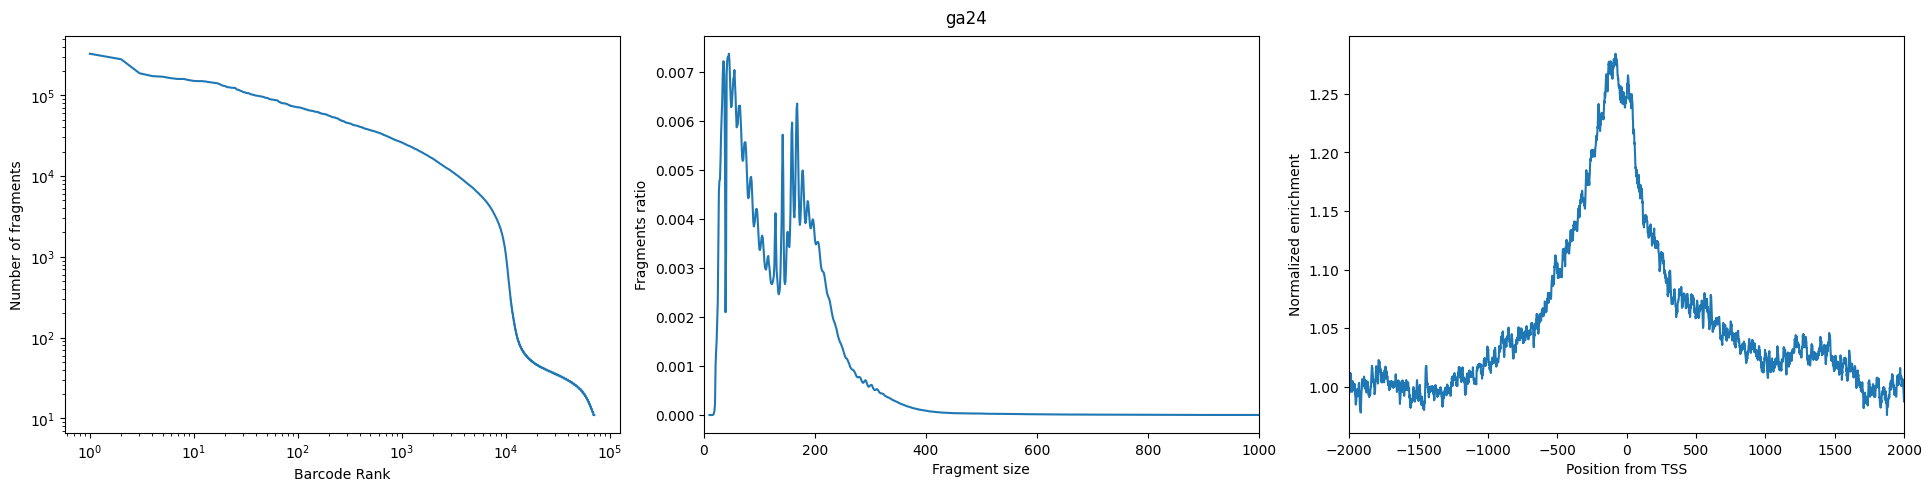

In [11]:
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = os.path.join(out_dir, "qc")
    )

In [12]:
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = os.path.join(out_dir, "qc"),
            unique_fragments_threshold = None, # use automatic thresholding
            tss_enrichment_threshold = None, # use automatic thresholding
            frip_threshold = 0,
            use_automatic_thresholds = True,
    )

1m:
	Using automatic threshold for unique fragments: 1214.5853040283805
	Using automatic threshold for TSS enrichment: 1.742530285948993
3m:
	Using automatic threshold for unique fragments: 1342.9853747058992
	Using automatic threshold for TSS enrichment: 1.5834907011528703
6m:
	Using automatic threshold for unique fragments: 1134.2431330034183
	Using automatic threshold for TSS enrichment: 1.486449504950495
10m:
	Using automatic threshold for unique fragments: 1312.4097916724675
	Using automatic threshold for TSS enrichment: 1.5211207920792078
1y:
	Using automatic threshold for unique fragments: 996.553091091284
	Using automatic threshold for TSS enrichment: 1.5731110557626589
2y:
	Using automatic threshold for unique fragments: 1188.7156968333486
	Using automatic threshold for TSS enrichment: 1.6757426605646697
4y:
	Using automatic threshold for unique fragments: 1367.5623346182203
	Using automatic threshold for TSS enrichment: 1.5950178742362109
ga22:
	Using automatic threshold for 

In [13]:
with open(os.path.join(out_dir, "sample_id_to_barcodes_passing_filters.pkl"), "wb") as file:
    pickle.dump(sample_id_to_barcodes_passing_filters, file)

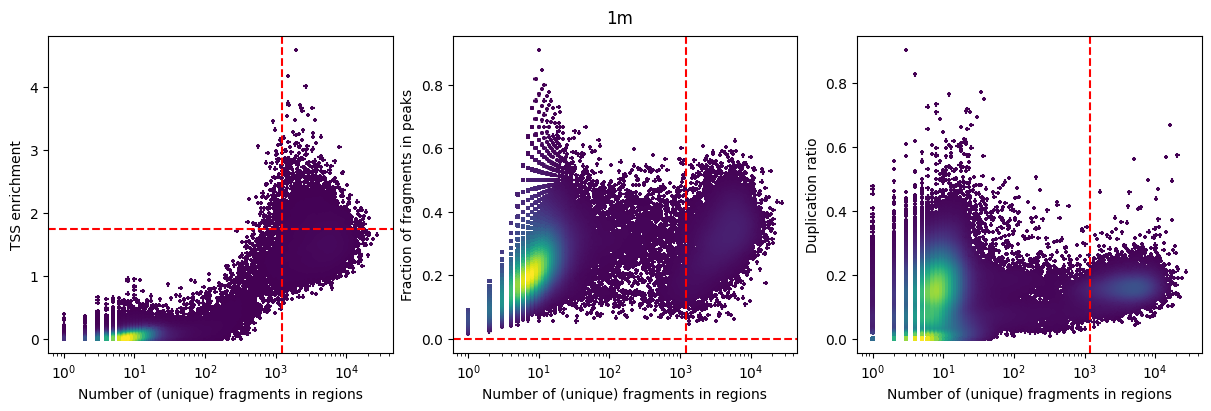

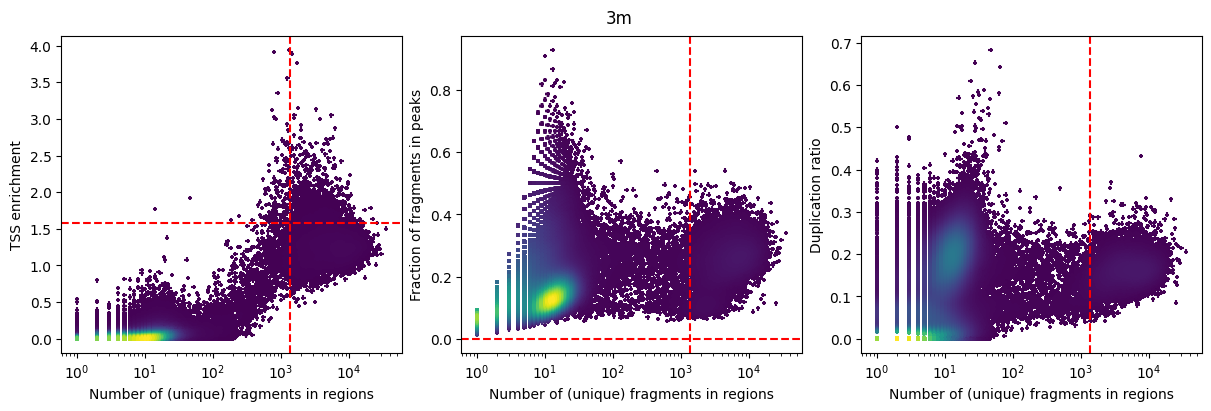

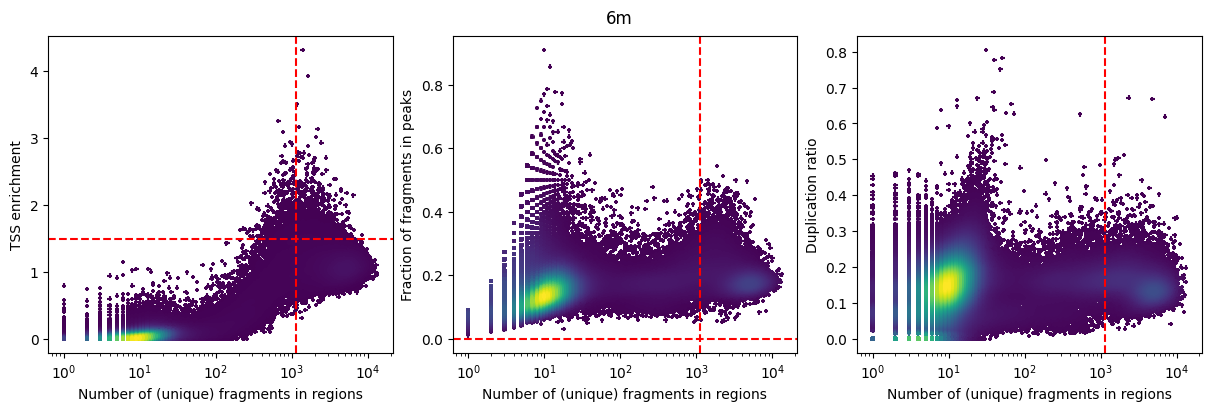

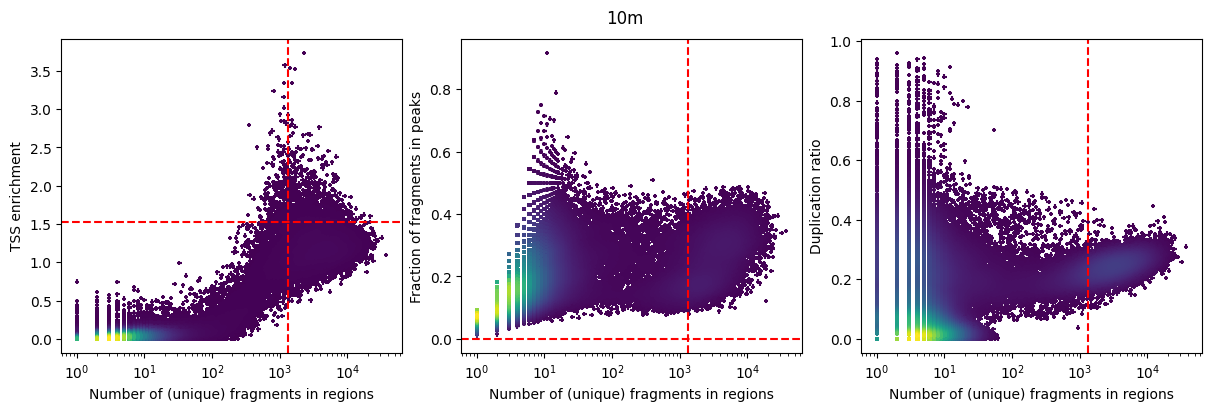

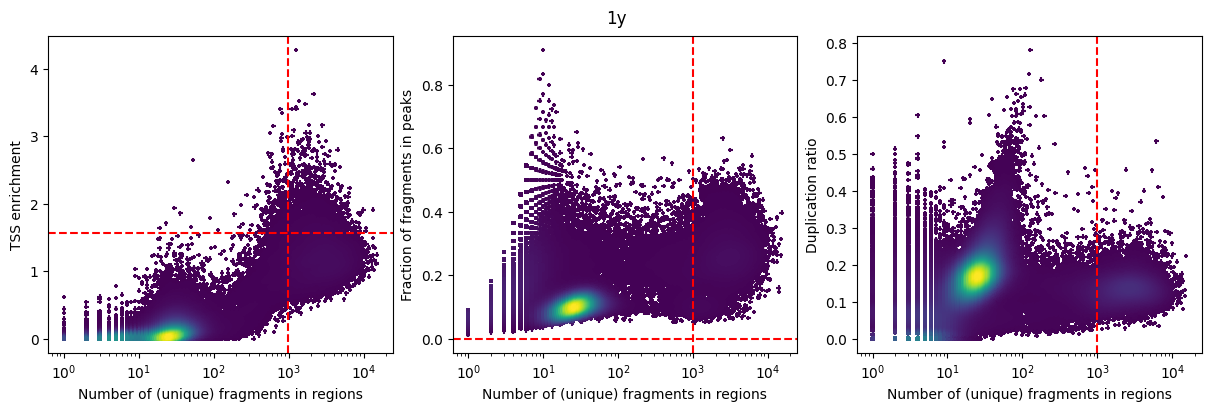

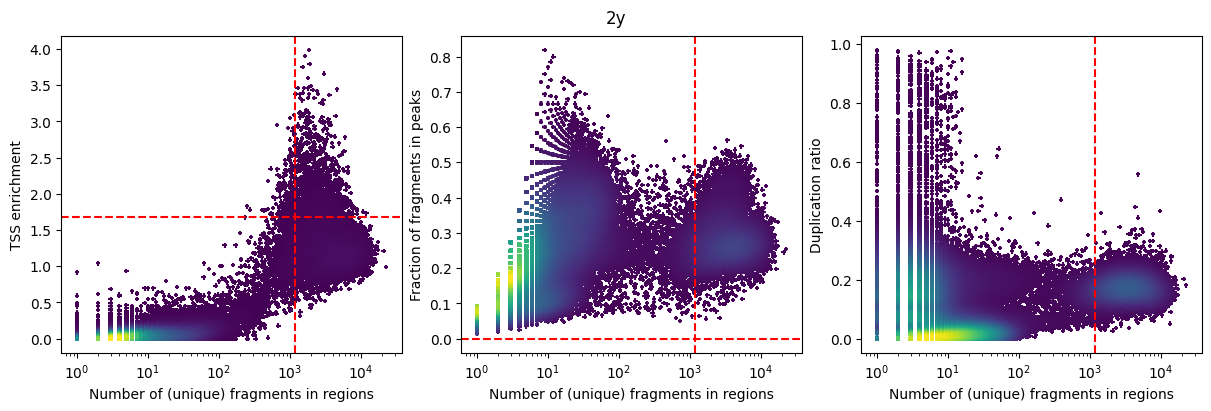

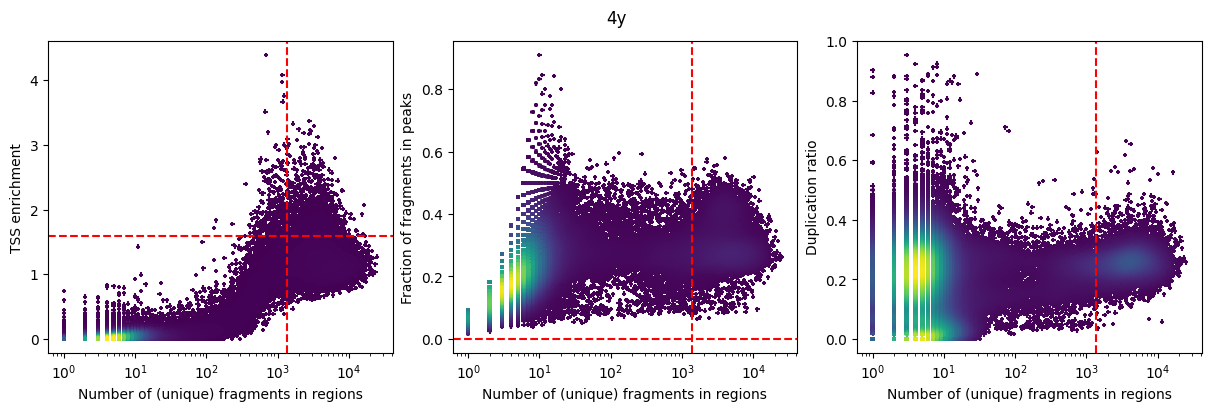

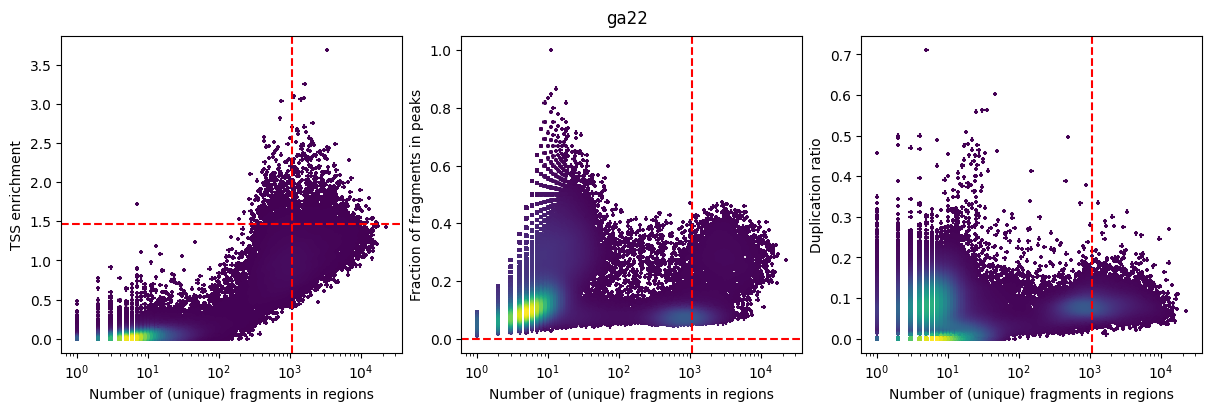

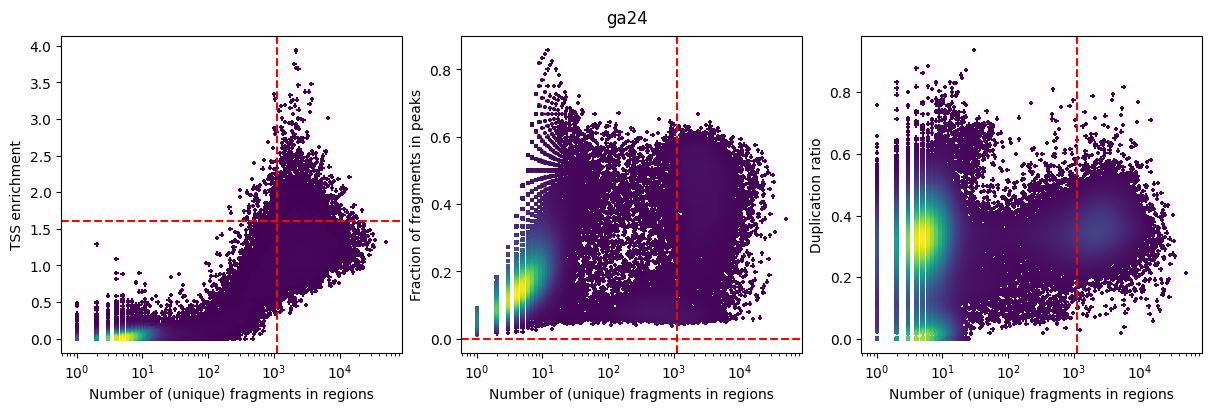

In [14]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = os.path.join(out_dir, "qc"),
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

In [15]:
gc.collect()

231329